# eager模式

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.executing_eagerly()

True

## eager模式下运算

In [2]:
# 在eager模式下可以直接进行运算
x = [[3.]]
m = tf.matmul(x, x)
print(m.numpy())

a = tf.constant([[1,9], [3,6]])
print(a)

b = tf.add(a, 2)
print(b)

print(a * b)

import numpy as np
s = np.multiply(a, b)
print(s)

[[9.]]
tf.Tensor(
[[1 9]
 [3 6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 3 11]
 [ 5  8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 3 99]
 [15 48]], shape=(2, 2), dtype=int32)
[[ 3 99]
 [15 48]]


## 动态控制流

In [3]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1
        
fizzbuzz(16)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16


## 构建模型

In [4]:
# 如果必须强制执行该层，则在构造函数中设置self.dynamic = True：
class MySimpleLayer(tf.keras.layers.Layer):
    def __init__(self, output_units):
        super(MySimpleLayer, self).__init__()
        self.output_units = output_units
        self.dynamic = True

    def build(self, input_shape):
        self.kernel = self.add_variable(
        "kernel", [input_shape[-1], self.output_units])

    def call(self, input):
        return tf.matmul(input, self.kernel)

In [5]:
# 构造一个模型
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=10)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        """Run the model."""
        result = self.dense1(inputs)
        result = self.dense2(result)
        result = self.dense2(result)  # reuse variables from dense2 layer
        return result

model = MNISTModel()

## 使用eager模式训练

In [6]:
# 计算梯度
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w*w
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


Logits:  [[ 0.00238419  0.03958656 -0.02439413 -0.0102925  -0.01509489  0.02502165
   0.04047041 -0.01105934  0.01557172  0.00571887]]
........................................

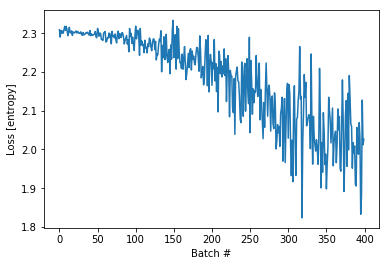

In [10]:
# 训练一个模型
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))

dataset = dataset.shuffle(1000).batch(32)

mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu', 
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

for images, labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []
for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

## 变量求导优化

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
        
    def call(self, inputs):
        return inputs * self.W + self.B

# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

# Define:
# 1. A model.
# 2. Derivatives of a loss function with respect to model parameters.
# 3. A strategy for updating the variables based on the derivatives.
model = MyModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# Training loop
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 69.508
Loss at step 000: 66.789
Loss at step 020: 30.267
Loss at step 040: 14.029
Loss at step 060: 6.810
Loss at step 080: 3.600
Loss at step 100: 2.173
Loss at step 120: 1.538
Loss at step 140: 1.256
Loss at step 160: 1.131
Loss at step 180: 1.075
Loss at step 200: 1.050
Loss at step 220: 1.039
Loss at step 240: 1.034
Loss at step 260: 1.032
Loss at step 280: 1.031
Final loss: 1.030
W = 3.0219900608062744, B = 1.996915340423584


## eager模式下的对象

In [12]:
# 变量即对象
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random.normal([1000, 1000]))
        v = None  # v no longer takes up GPU memory

In [13]:
# 对象保存
x = tf.Variable(6.0)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(1.0)
checkpoint.save('ch6/ckpt/')

x.assign(8.0)
checkpoint.restore(tf.train.latest_checkpoint('ch6/ckpt/'))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [14]:
# 模型保持
import os

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint_dir = 'ch6/ck_model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [15]:
# 面向对象的指标
m = tf.keras.metrics.Mean('loss')
m(0)
m(5)
print(m.result())  # => 2.5
m([8, 9])
print(m.result())  # => 5.5

tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float32)


## 高级自动分化主题

In [16]:
# 动态模型

def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # Variables are automatically recorded, but manually watch a tensor
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

In [17]:
# 自定义梯度
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    
    return y, grad_fn

In [18]:
# 自定义梯度可以提供数值稳定的梯度
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)


print(grad_log1pexp(tf.constant(0.)).numpy())
# However, x = 100 fails because of numerical instability.
print(grad_log1pexp(tf.constant(100.)).numpy())

0.5
nan


这里，log1pexp函数可以使用自定义梯度求导进行分析简化。 下面的实现重用了在前向传递期间计算的tf.exp（x）的值 - 通过消除冗余计算使其更有效：

In [19]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    
    return tf.math.log(1 + e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

print(grad_log1pexp(tf.constant(0.)).numpy())
print(grad_log1pexp(tf.constant(100.)).numpy())

0.5
1.0


## 使用gpu提升性能

In [21]:
import time

def measure(x, steps):
    # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    # tf.matmul can return before completing the matrix multiplication
    # (e.g., can return after enqueing the operation on a CUDA stream).
    # The x.numpy() call below will ensure that all enqueued operations
    # have completed (and will also copy the result to host memory,
    # so we're including a little more than just the matmul operation
    # time).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.test.is_gpu_available():
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 2.6852359771728516 secs
GPU: not found


In [22]:
if tf.test.is_gpu_available():
    x = tf.random.normal([10, 10])

    x_gpu0 = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
    _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0